# LGT Quick Start

LGT stands for Local and Global Trend, which is an important model type in orbit package. In the model equation, there is a local trend term and a global trend term.

In this notebook we will show how to use Orbit LGT models with the US unemployment claims data.

**Note: Negative response values are not allowed in LGT model, due to the existence of the global trend term.**

In [1]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job)from Jan 2010 - June 2018. 
This aims to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).
Note that dataset is transformed by natural log before fitting in order to be fitted as a multiplicative model.

In [2]:
# load data
df = load_iclaims()

# define date and response column
date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [3]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033,-0.454779,0.071726
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326,-0.462627,0.059517
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033,-0.502375,0.481411
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451,-0.518897,0.377717
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016,-0.526075,0.436476


### Train / Test Split

In [4]:
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

In [5]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033,-0.454779,0.071726
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326,-0.462627,0.059517
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033,-0.502375,0.481411
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451,-0.518897,0.377717
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016,-0.526075,0.436476


## LGT Model

In orbit, we have three types of LGT models, `LGTMAP`, `LGTAggregated` and  `LGTFull`.
Orbit follows the sklearn model API. We can create an instance of the Orbit class and then call its fit and predict methods.

### LGTMAP

LGT model for MAP (Maximum a Posteriori) prediction

In [6]:
lgt = LGTMAP(
    response_col=response_col,
    regressor_col = 'trend.unemploy',
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

LGT model
warning


In [ ]:
%%time
lgt.fit(df=train_df)

In [8]:
predicted_df = lgt.predict(df=test_df)

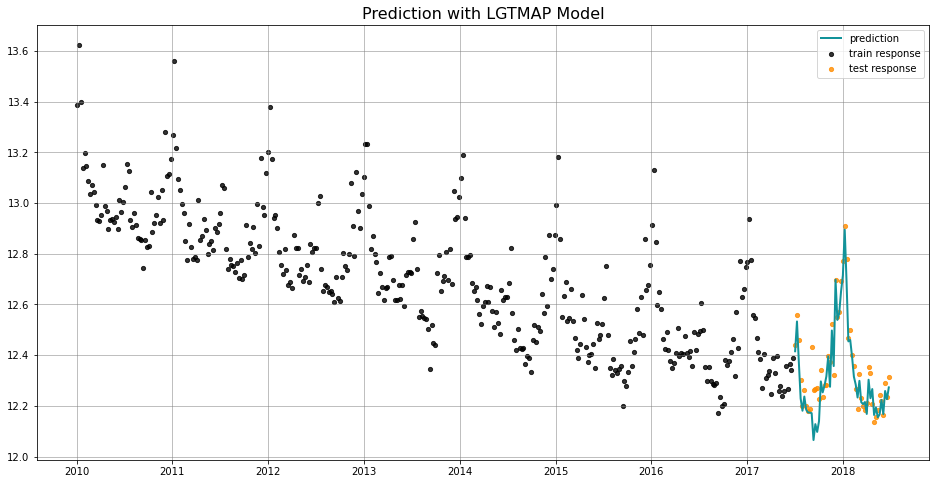

In [9]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col,  
                        test_actual_df=test_df, title='Prediction with LGTMAP Model')

### LGTFull

LGT model for full prediction. In full prediction, the prediction occurs as a function of each parameter posterior sample, and the prediction results are aggregated after prediction. Prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified.

In [10]:
lgt = LGTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [11]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 79.2 ms, sys: 69.7 ms, total: 149 ms
Wall time: 9.32 s


In [12]:
predicted_df = lgt.predict(df=test_df)

In [13]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.099949,12.232984,12.330652
48,2018-06-03,12.060341,12.173674,12.293869
49,2018-06-10,12.118473,12.262561,12.408782
50,2018-06-17,12.097858,12.239122,12.341881
51,2018-06-24,12.193468,12.281816,12.383324


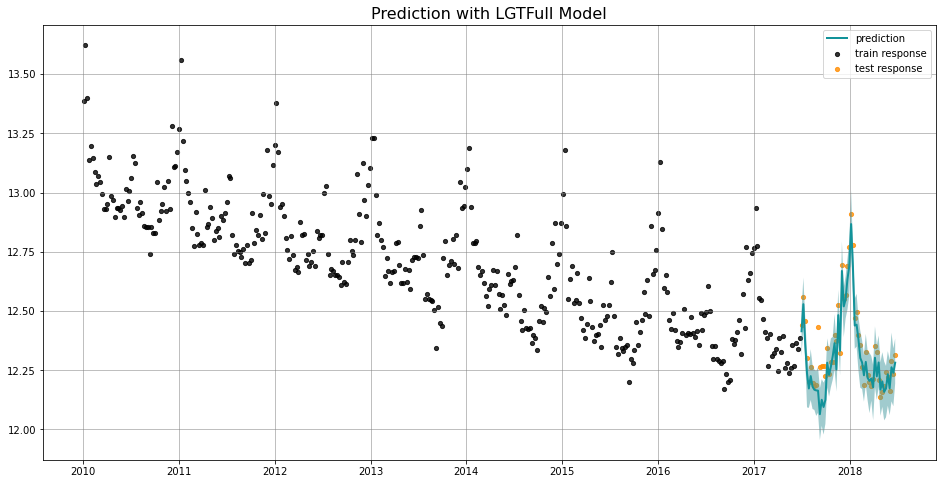

In [14]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Prediction with LGTFull Model')

### LGTAggregated

LGT model for aggregated posterior prediction. In aggregated prediction, the parameter posterior samples are reduced using `aggregate_method ({ 'mean', 'median' })` before performing a single prediction.

In [15]:
lgt = LGTAggregated(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [16]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 88.6 ms, sys: 77.3 ms, total: 166 ms
Wall time: 9.29 s


In [17]:
predicted_df = lgt.predict(df=test_df)

In [18]:
predicted_df.tail(5)

,week,prediction
47,2018-05-27,12.204437
48,2018-06-03,12.139519
49,2018-06-10,12.233509
50,2018-06-17,12.200898
51,2018-06-24,12.247008


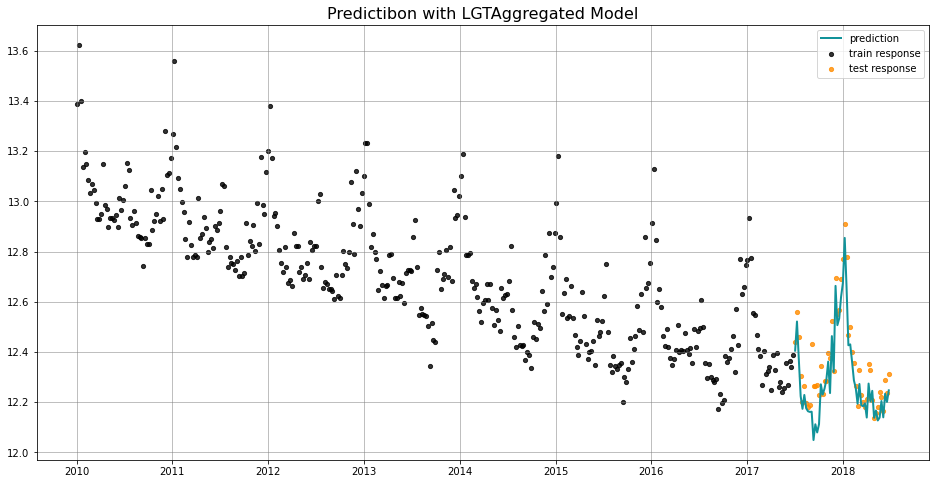

In [19]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df, title='Predictibon with LGTAggregated Model')

More details for each method are available in the docstrings and also here: https://uber.github.io/orbit/orbit.models.html#module-orbit.models.lgt